Merged shape: (1068, 935)
T1-Ch shape: (79, 935)
1    16
2     7
3    28
4    28
Name: group, dtype: int64 

Train size: (55, 928)   Test size: (24, 928)

Train label counts:
 1    11
2     5
3    19
4    20
dtype: int64

Test  label counts:
 1    5
2    2
3    9
4    8
dtype: int64 

Best k selected: 5
Macro F1 score: 0.29395604395604397 

Confusion matrix:
 [[3 0 2 0]
 [0 0 2 0]
 [3 0 4 2]
 [2 0 4 2]] 

Classification report:
               precision    recall  f1-score   support

           1       0.38      0.60      0.46         5
           2       0.00      0.00      0.00         2
           3       0.33      0.44      0.38         9
           4       0.50      0.25      0.33         8

    accuracy                           0.38        24
   macro avg       0.30      0.32      0.29        24
weighted avg       0.37      0.38      0.35        24


 y_test  vs  y_pred  (T1-Ch):
     y_test  y_pred
1        3       4
2        3       1
3        1       3
4        2       3
5    

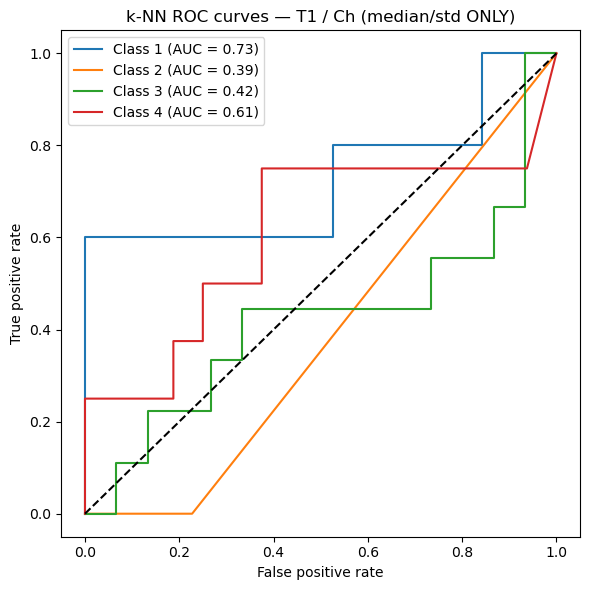

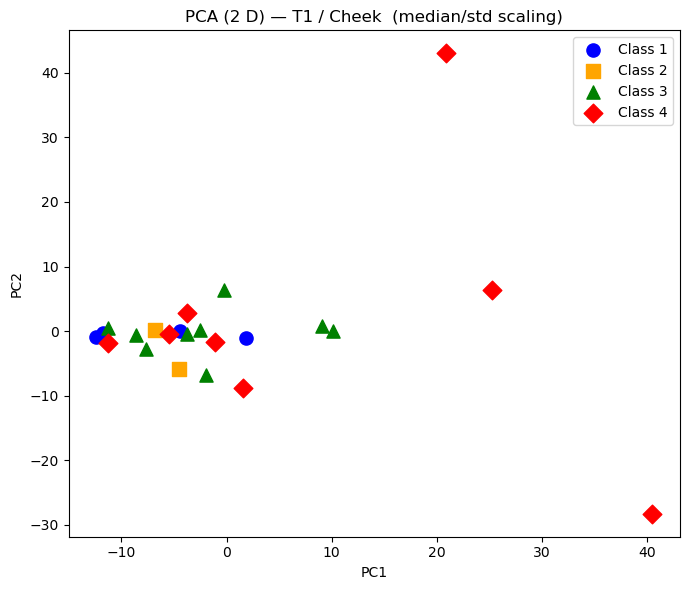

In [1]:
# ===============================================================
#   k-NN  —  T1  /  Cheek   (median / std scaling ONLY)   •  AUTO-OPTIMIZED k
# ===============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from sklearn.exceptions            import UndefinedMetricWarning
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import FunctionTransformer, label_binarize
from sklearn.pipeline              import Pipeline
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.metrics               import (f1_score, confusion_matrix,
                                           classification_report,
                                           roc_curve, auc)
from sklearn.decomposition         import PCA

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# ----------------------------------------------------------------
# 1. LOAD  +  MERGE
df_micro = (pd.read_csv("Vitality_microbialAbundance_table.csv")
              .rename(columns={"Unnamed: 0": "met_id"}))
df_meta  = (pd.read_csv("Vitality_metadata_table.csv")
              .rename(columns={"Unnamed: 0": "met_id"}))

meta_cols = ["met_id", "subject_id", "site_specific", "visit", "group",
             "group_eczemaYesOrNo", "group_eczema_affectedSkin"]
df        = df_micro.merge(df_meta[meta_cols], on="met_id", how="inner")
print("Merged shape:", df.shape)

# ----------------------------------------------------------------
# 2. SUBSET  ►  T1   +   Cheek
mask      = (df["visit"] == "T1") & (df["site_specific"] == "Ch")
df_t1_ch  = df.loc[mask].reset_index(drop=True)
print("T1-Ch shape:", df_t1_ch.shape)
print(df_t1_ch["group"].value_counts().sort_index(), "\n")

# ----------------------------------------------------------------
# 3. TRAIN / TEST  SPLIT
drop_cols    = ["met_id", "subject_id",
                "site_specific", "visit", "group",
                "group_eczemaYesOrNo", "group_eczema_affectedSkin"]
feature_cols = [c for c in df_t1_ch.columns if c not in drop_cols]

train_df, test_df = train_test_split(
        df_t1_ch, test_size=0.30, stratify=df_t1_ch["group"], random_state=42)

X_train, y_train = train_df[feature_cols].values, train_df["group"].values
X_test , y_test  =  test_df[feature_cols].values,  test_df["group"].values

print("Train size:", X_train.shape, "  Test size:", X_test.shape)
print("\nTrain label counts:\n", pd.Series(y_train).value_counts().sort_index())
print("\nTest  label counts:\n",  pd.Series(y_test ).value_counts().sort_index(), "\n")

# ----------------------------------------------------------------
# 4.  MEDIAN / STD  SCALER  (NO LOG)
def median_std(X):
    X   = X.astype(float)
    med = np.median(X, axis=0)
    std = np.std   (X, axis=0)
    std[std == 0] = 1.0
    return (X - med) / std

median_std_tf = FunctionTransformer(median_std)

# ----------------------------------------------------------------
# 5.  AUTO-OPTIMIZE  k  USING  VALIDATION  SPLIT
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

k_scores = {}

for k in range(1, 16, 2):
    pipe_tmp = Pipeline([
        ("scale", median_std_tf),
        ("knn",   KNeighborsClassifier(n_neighbors=k, weights="distance"))
    ])
    pipe_tmp.fit(X_tr, y_tr)
    y_val_pred = pipe_tmp.predict(X_val)
    k_scores[k] = f1_score(y_val, y_val_pred, average="macro")

best_k = max(k_scores, key=k_scores.get)
print("Best k selected:", best_k)

# ----------------------------------------------------------------
# 6.  FINAL  MODEL  WITH  OPTIMAL  k
pipe = Pipeline([
    ("scale", median_std_tf),
    ("knn",   KNeighborsClassifier(n_neighbors=best_k, weights="distance"))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# ----------------------------------------------------------------
# 7. METRICS
print("Macro F1 score:", f1_score(y_test, y_pred, average="macro"), "\n")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred), "\n")
print("Classification report:\n",
      classification_report(y_test, y_pred, zero_division=0))

tbl = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
tbl.index = np.arange(1, len(tbl)+1)
print("\n y_test  vs  y_pred  (T1-Ch):\n", tbl.to_string(), "\n")

# ----------------------------------------------------------------
# 8. MIS-CLASSIFIED  rows
mis_idx = np.where(y_test != y_pred)[0]
chk = (test_df.iloc[mis_idx][["met_id","group",
                              "group_eczemaYesOrNo","group_eczema_affectedSkin"]]
        .assign(y_test=y_test[mis_idx], y_pred=y_pred[mis_idx]))

chk.index = np.arange(1, len(chk)+1)
print("Mis-classified rows — check 1_yes, 3_yes_no tags etc.:\n",
      chk.to_string(), "\n")

# ----------------------------------------------------------------
# 9. ROC  CURVES
classes = np.sort(np.unique(y_train))
y_bin   = label_binarize(y_test, classes=classes)
y_prob  = pipe.predict_proba(X_test)

plt.figure(figsize=(6,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("k-NN ROC curves — T1 / Ch (median/std ONLY)")
plt.legend(); plt.tight_layout(); plt.show()

# ----------------------------------------------------------------
# 10. PCA  (test set visual)
X_test_std = median_std_tf.transform(X_test)
X_2d       = PCA(n_components=2).fit_transform(X_test_std)

mk = {1:"o",2:"s",3:"^",4:"D"} ; cl = {1:"blue",2:"orange",3:"green",4:"red"}
plt.figure(figsize=(7,6))
for c in np.unique(y_test):
    idx = y_test == c
    plt.scatter(X_2d[idx,0], X_2d[idx,1], c=cl[c], marker=mk[c], s=90, label=f"Class {c}")

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA (2 D) — T1 / Cheek  (median/std scaling)")
plt.legend(); plt.tight_layout(); plt.show()